# Task
Задача отличать поддельные подписи от настоящих.

Способ решения:
На вход модели подаются два изображения содержащих подписи. Модель возвращает два embedding соответствующих этим изображениям. Далее нужно сравнить эти embedding и оценить вероятность того что подписи были сделаны одним и тем же человеком


Данные и идея позаимствованны с Kaggle:

[kaggle signature verification dataset](https://www.kaggle.com/robinreni/signature-verification-dataset) 



<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/EX2.png" width="600">

Датасет состоит из набора сканов подписей разложенным по папкам


> id1

> id1_forg

> id2

> id2_forg

> ...


в папке id1 содержатся сканы полинных подписей одного человека. В папке id1_forg содержатся сканы поддельных подписей того же человека.

В папках с перфиксом id2, id2_forg - настоящие и поддельные подписи другого человека и.т.д.

### Dataset :

Фрагмент датасета достаточный для выполнения задания доступен по ссылке::  http://edunet.kea.su/repo/src/L11_Transfer_learning/sign_mini.zip 


In [ ]:
!wget http://edunet.kea.su/repo/src/L11_Transfer_learning/sign_mini.zip
!unzip sign_mini.zip

--2023-03-01 14:19:33--  http://edunet.kea.su/repo/src/L11_Transfer_learning/sign_mini.zip
Resolving edunet.kea.su (edunet.kea.su)... 188.44.53.138
Connecting to edunet.kea.su (edunet.kea.su)|188.44.53.138|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://edunet.kea.su/repo/src/L11_Transfer_learning/sign_mini.zip [following]
--2023-03-01 14:19:34--  https://edunet.kea.su/repo/src/L11_Transfer_learning/sign_mini.zip
Connecting to edunet.kea.su (edunet.kea.su)|188.44.53.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117642785 (112M) [application/zip]
Saving to: ‘sign_mini.zip’

sign_mini.zip       100%[===================>] 112.19M  5.75MB/s    in 11s     

2023-03-01 14:19:45 (10.6 MB/s) - ‘sign_mini.zip’ saved [117642785/117642785]

Archive:  sign_mini.zip
   creating: sign_data_mini/
  inflating: sign_data_mini/.DS_Store  
   creating: sign_data_mini/test/
  inflating: sign_data_mini/test/.DS_Store  
   cre

Класс датасета дан готовым. 


В отличие от датасетов для классификации, метод __getitem__ возвращает кортеж и 3-х а не двух элементов:



1.   Реальная подпись соответствующая индексу `index`
2.   Подпись с которой ее нужно сравнить. С вероятностью 0.5 это может быть  другая настоящая подпись, а с вероятностью 0.5 подделка.
3. Менка соответствующая истинному результату сопоставления. Для двух настоящих пописей это **1** для ситуации когда одна из подписей поддельная это **-1**


Необходимости изменять этот класс нет, однако это допустимо.

In [ ]:
import random
import os
from glob import glob
from itertools import product

from PIL import Image
from torch.utils.data import Dataset


class SiameseNetworkDataset(Dataset):
    def __init__(self, dir=None, transform=None):
        self.dir = dir
        self.transform = transform
        self.classes = {1: "Orginial", -1: "Forged"}  # Change if need
        self.data = self.get_pairs()
        self.targets = self.get_targets()
        self.cache = {}

    def get_pairs(self):
        pairs = []  # to store [orig, fake] or [orig,orig] pairs
        persons = self.load_data()
        for key in persons:
            all_pairs = product(
                persons[key]["orig"], persons[key]["orig"] + persons[key]["forg"]
            )
            # remove pairs with themselve
            without_self_comparsion = list(filter(lambda x: x[0] != x[1], all_pairs))
            pairs += without_self_comparsion
        return pairs

    def load_data(self):
        all_paths = glob(f"{self.dir}/**/*")  # get all files path
        persons = {}
        # Group files by ID and type
        for path in all_paths:
            id, tp = SiameseNetworkDataset.parse(path)
            if not id in persons:
                persons[id] = {"orig": [], "forg": []}
            persons[id][tp].append(path)
        return persons

    def get_targets(self):
        targets = []
        for pair in self.data:
            _, tp = SiameseNetworkDataset.parse(pair[1])
            label = -1 if tp == "forg" else 1
            targets.append(label)
        return targets

    @staticmethod
    def parse(path):
        folder = path.split(os.sep)[-2]
        id = folder.split("_")[0]
        tp = "forg" if "forg" in path else "orig"
        return id, tp

    def __getitem__(self, index):
        image0_path, image1_path = self.data[index]
        label = self.targets[index]

        # Loading the images
        img0 = self.load(image0_path)
        img1 = self.load(image1_path)

        return img0, img1, label

    def load(self, path):
        if path in self.cache:
          img = self.cache[path]
        else:
          img = Image.open(path).convert("L")
          self.cache[path] = img
        # Apply image transformations
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)

Создадим экземпляр датасета и убедимся что данные загружаются

"1" - подписи настоящие, "-1" - подделка


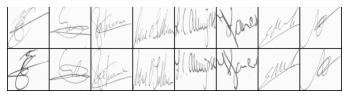

[-1  1  1 -1  1  1  1  1]


In [ ]:
from torch.utils.data import  DataLoader
import torch
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

# Viewing the sample of images to check whether its loading properly
print('"1" - подписи настоящие, "-1" - подделка')

vis_dataset = SiameseNetworkDataset(
  "/content/sign_data_mini/train", 
  transform=transforms.Compose([
    transforms.Resize((105,105)),
    transforms.ToTensor(),
  ])
)

vis_dataloader = DataLoader(vis_dataset, batch_size=8, shuffle=True)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter) # img1, img2, label
# display the data
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
grid = utils.make_grid(concatenated)

plt.axis("off")
plt.rcParams["figure.figsize"] = (20,40)
plt.imshow(grid.permute(1,2,0).numpy())
plt.show()    

print(example_batch[2].numpy())

Создание тренировочного и тестового датасета и даталоадера. 
В отличие варианта для визуализации к трансформациям добавилась нормализация.

Этот блок можно модифицировать не требуется, но допускается.



In [ ]:
# Define transforms include Standartization
trans = transforms.Compose([
    transforms.Resize((105,105)),
    transforms.ToTensor(),
    transforms.Normalize(0.9409,0.1078)
])

# Load the dataset as pytorch tensors using dataloader
train_dataset = SiameseNetworkDataset(dir="/content/sign_data_mini/train", transform=trans)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)

# Load the test dataset
test_dataset = SiameseNetworkDataset(dir="/content/sign_data_mini/test", transform=trans)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## Siamese Network Definition

В данном блоке нужно описать структуру модели.

На вход модели поступают **два** одноканальных изображения а не одно. На выходе **два** вектора - признака (embeddings). Размер embedding подберите самостоятельно.



Допускается использовать в качестве основы готовые модели из torchvision

In [ ]:
from torch import nn

IMAGE_SIZE = 105
CONV_CHANNELS = [32, 64, 128]
CONV_SIZE = int(IMAGE_SIZE/2**len(CONV_CHANNELS))
LINEAR_FEAT = CONV_CHANNELS[-1] * CONV_SIZE**2

class CNN(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.latent_size = latent_size

    layers = []
    for in_c, out_c in zip([1]+CONV_CHANNELS[:-1], CONV_CHANNELS):
      layers.append(nn.Conv2d(in_c, out_c, kernel_size=2, stride=2))
      layers.append(nn.BatchNorm2d(out_c))
      layers.append(nn.ReLU())
    layers.append(nn.Flatten())

    self.conv = nn.Sequential(*layers)
    self.linear = nn.Linear(in_features=LINEAR_FEAT, out_features=latent_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.relu(self.linear(self.conv(x)))

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self, latent_size=128):
    super().__init__()
    self.latent_size = latent_size
    self.cnn = CNN(latent_size)

  def forward(self, input1, input2):
    output1 = self.cnn(input1)
    output2 = self.cnn(input2)
    return output1, output2

model = SiameseNetwork()

## Accuracy

Вспомогательный метод для подсчета accuracy с использованием порога и косинусного расстояния.

 Пара подписей считаются принадлежащими одному человеку, если косинусное расстояние между ними меньше порога по умолчанию равного 0.5. Иначе одна из подписей считается подделкой.



In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validation(model, dl, threshold = 0.5):
  model.eval()
  model.to(device)
  predicts = []
  gt = []
  sim = nn.CosineSimilarity()
  for i, data in enumerate(dl): 
     x0, x1 , label = data
     out1,out2 = model(x0.to(device),x1.to(device))
     dist = sim(out1, out2) 
     gt.append(label.flatten())
     dist[dist < threshold] = -1 # Forged
     dist[dist > threshold] = 1 # Original 
     predicts.append(dist.flatten().detach().cpu())
  predicts = torch.cat(predicts).numpy().astype(float)
  gt = torch.cat(gt).cpu().squeeze().detach().numpy()
  return accuracy_score(predicts,gt)

validation(model, test_dataloader) # accuracy ~ 0.5 on untrained model

0.5076923076923077

# Train 

Блок кода для обучения.Требуется:


*   Задать Loss - функцию
*   Написать цикл обучения
*   Вывести графики loss и accuracy в Tensorboard


In [24]:
from torch import optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="basic", flush_secs=3)
def train(model, train_dataloader, test_dataloader, lr=1, epochs=10):
    # Decalre Loss Function
    criterion = nn.CosineEmbeddingLoss()
    # Declare Optimizer
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    model.to(device)

    i = 0
    test_i = 0
    for epoch in range(epochs):
      model.train()

      loss_sum = 0
      total = 0
      for x0, x1, label in tqdm(train_dataloader, desc=f"Epoch {epoch:03}: Training"):
        optimizer.zero_grad()
        out1, out2 = model(x0.to(device), x1.to(device))
        loss = criterion(out1, out2, label.to(device))
        loss.backward()
        optimizer.step()

        i += 1
        loss_sum += loss.item() * label.size()[0]
        total += label.size()[0]
        writer.add_scalar(f"train/step loss", loss.item(), i)
      loss_sum /= total
      writer.add_scalar(f"train/epoch loss", loss_sum, epoch)


      with torch.no_grad():
        model.eval()
        loss_sum = 0
        total = 0
        for x0, x1, label in tqdm(test_dataloader, desc=f"Epoch {epoch:03}:  Testing"):
          out1, out2 = model(x0.to(device), x1.to(device))
          loss = criterion(out1, out2, label.to(device))

          test_i += 1
          loss_sum += loss.item() * label.size()[0]
          total += label.size()[0]
          writer.add_scalar(f"test/step loss", loss.item(), test_i)
        loss_sum /= total
        writer.add_scalar(f"test/epoch loss", loss_sum, epoch)

    return model

Запуск Tensorboard

In [ ]:
  %load_ext tensorboard
  %tensorboard --logdir runs

Запуск обучения

In [ ]:
# Train the model
model = SiameseNetwork()
model = train(model, train_dataloader, test_dataloader)

# Test

Вспомогательный код для вывода изображений 

In [19]:
import numpy as np
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (10,20)
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

Визуализация результатов сравнения

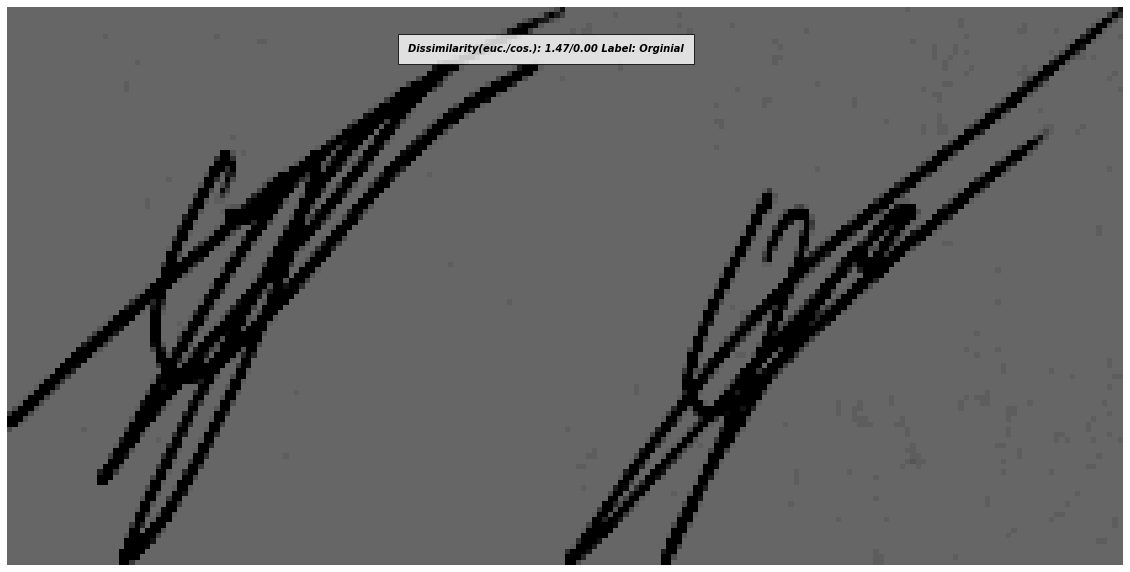

Dissimilarity:
Euclidean dist:  1.47 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


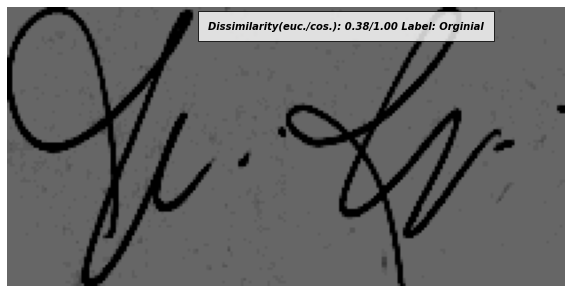

Dissimilarity:
Euclidean dist:  0.38 [0 .. inf ]
Cosine dist  1.00 [-1 .. 1]


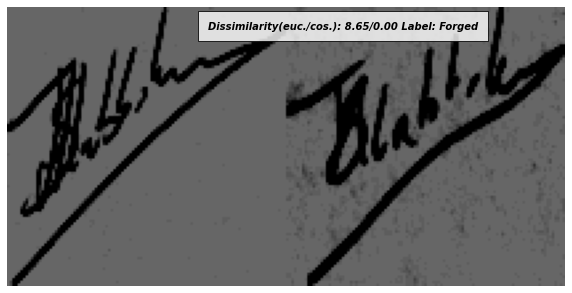

Dissimilarity:
Euclidean dist:  8.65 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


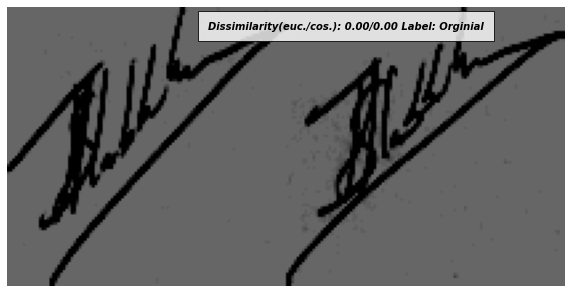

Dissimilarity:
Euclidean dist:  0.00 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


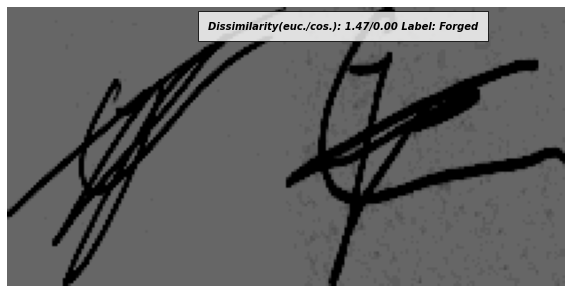

Dissimilarity:
Euclidean dist:  1.47 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


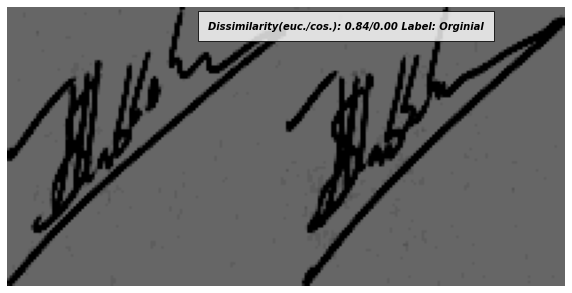

Dissimilarity:
Euclidean dist:  0.84 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


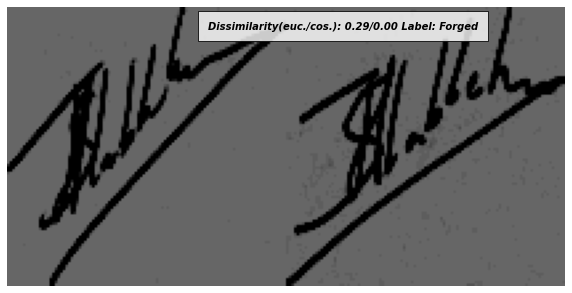

Dissimilarity:
Euclidean dist:  0.29 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


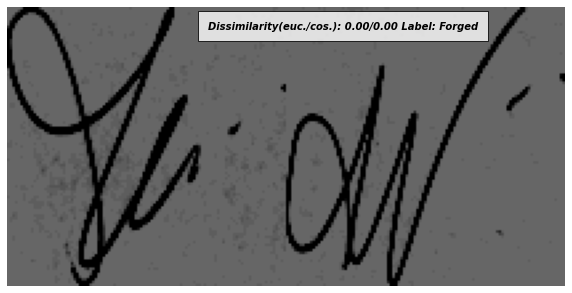

Dissimilarity:
Euclidean dist:  0.00 [0 .. inf ]
Cosine dist  0.00 [-1 .. 1]


In [20]:
import torch.nn.functional as F
# Print the sample outputs to view its dissimilarity
for i, batch in enumerate(test_dataloader): 
  x0, x1 , label_id = batch
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
  cosine_distance = F.cosine_similarity(output1, output2)

  for i in range(label_id.shape[0]):
    concatenated = torch.cat((x0[i][0],x1[i][0]),1)
    label = test_dataset.classes[label_id[i].item()]
    imshow(utils.make_grid(concatenated),'Dissimilarity(euc./cos.): {:.2f}/{:.2f} Label: {}'.format(eucledian_distance[i].item(),cosine_distance[i].item(),label))

    print('Dissimilarity:')
    print(f"Euclidean dist:  {eucledian_distance[i].item():.2f} [0 .. inf ]")
    print(f"Cosine dist  {cosine_distance[i].item():.2f} [-1 .. 1]")
       
  break


### Accuracy Check

Финальная оценка точности

In [21]:
validation(model, test_dataloader)

0.5679487179487179

In [22]:
validation(model, train_dataloader)

0.9681767427021853

### **ВЫВОД:**
Модель только на 6% лучше рандома, что оставляет желать лучшего. У нас конечно очень маленький датасет, и она ужасно оверфититься. На трейне у неё accuracy аж 96%... Попробую её запустить с другими параметрами, и на больше эпох

# Эксперементируем

In [27]:
!rm -rf runs/

In [ ]:
writer = SummaryWriter(comment="basic", flush_secs=3)
model = SiameseNetwork()
model = train(model, train_dataloader, test_dataloader, epochs=20)

In [ ]:
writer = SummaryWriter(comment="small latent space", flush_secs=3)
model = SiameseNetwork(16)
model = train(model, train_dataloader, test_dataloader, epochs=20)

In [ ]:
writer = SummaryWriter(comment="big latent space", flush_secs=3)
model = SiameseNetwork(512)
model = train(model, train_dataloader, test_dataloader, epochs=20)

In [ ]:
writer = SummaryWriter(comment="med(32) latent space", flush_secs=3)
model = SiameseNetwork(32)
model = train(model, train_dataloader, test_dataloader, epochs=10)
validation(model, test_dataloader)

In [ ]:
writer = SummaryWriter(comment="med(64) latent space", flush_secs=3)
model = SiameseNetwork(64)
model = train(model, train_dataloader, test_dataloader, epochs=15)
validation(model, test_dataloader)

ой... Это уже хуже рандома... Как...? 0_0

# Вывод №2

Лучшея accuracy у меня получилась с размером latent space-а 32: 64.8%.
Это конечно не хорошо. Скорее всего у меня непраивльно выбрана нейронка. Может быть в ней слишком много конволюций.

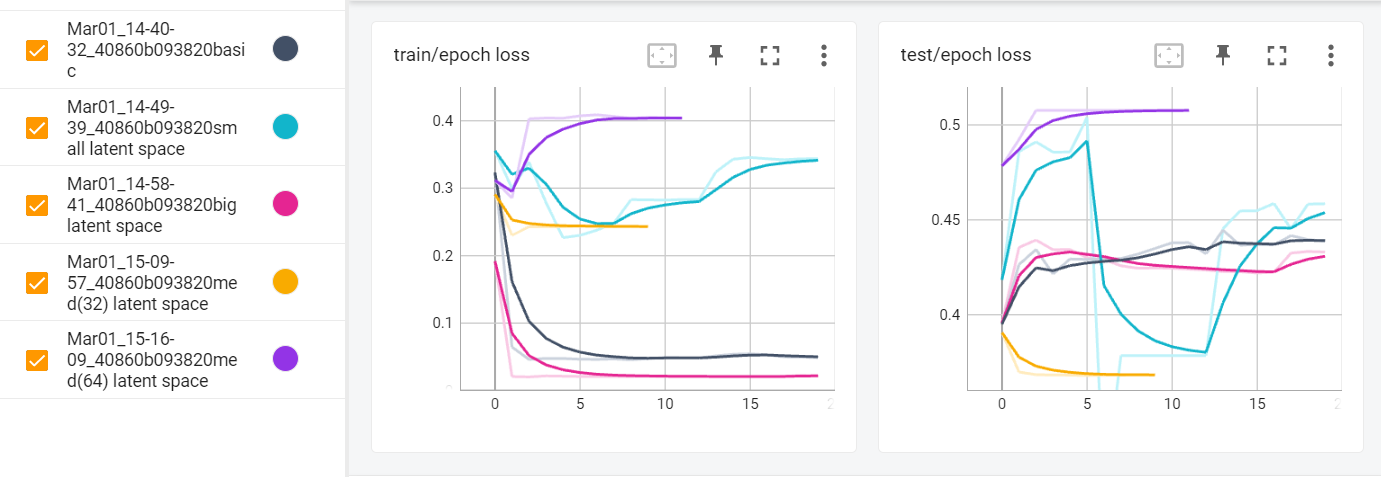

# Идеи для дальнейшей работы


*   Порог 0.5 при котором считается accuracy выбран произвольно, можно экспериментально подобрать значение порога при котором accuracy будет максимальной
*   Построить DET кривую